# Load in Libraries

In [1]:
#Homemade Functions
from functions.functions_analysis import *
from functions.Path_combine_function import *
from functions.plot_functions import *
from functions.Preproc_functions import *

#More nifti packages
from nilearn import plotting
import nibabel as nib

# Dipy
import dipy as dp
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.data as dpd
from dipy.tracking import utils

#Preproc
from dipy.align import motion_correction
import dipy.direction.peaks as dpp
from dipy.viz import window, actor
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq


#DIPY Plot
from dipy.viz import window, actor, colormap
from dipy.data import get_sphere, default_sphere, get_fnames

#Regular Packages
import keyboard  # For detecting keypresses
import IPython
import pickle #loading pkl files (dictonairy)
import pandas as pd


import numpy as np
import os
from pathlib import Path
from time import time
import time  # For simulating work
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy.io

#Plot packages
import napari

#Model Packages
from dipy.direction import peaks_from_model
from dipy.reconst.dti import color_fa
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.dti import TensorModel
from dipy.reconst.shm import CsaOdfModel
import dipy.reconst.sfm as sfm
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.tracking.stopping_criterion import (ActStoppingCriterion,
                                              BinaryStoppingCriterion,
                                              ThresholdStoppingCriterion)

# **Rules For Q-ball Model Setting**

**sh_order:**
- If peaks look noisy or unstable → Lower sh_order. If peaks miss fiber crossings → Increase sh_order
- Minimum required b-value: 
    - Higher sh_order requires higher b-values (≥2000 s/mm² recommended for high orders).
- Minimum required number of gradient directions:
    - The number of directions (N) must be ≥ (sh_order + 1)² / 2. This ensures that the model is not overfitting with too few samples.
- Recomendation:
    - sh_order = 4 → Safe choice for low b-values (b < 1000 s/mm²) and small datasets.
    - sh_order = 6 → Works well for most dMRI data (b = 1000-2000 s/mm², ≥30 directions).
    - sh_order = 8 → Best for high b-values and high-resolution dMRI (≥ 60 directions).
    - sh_order = 10+ → Only use if you have very high b-values (b ≥ 3000 s/mm²) and 90+ direction


**Other Params:**
- relative_peak_threshold = 0.4, # Defines the minimum amplitude a peak must have relative to the highest peak in a voxel to be considered a valid fiber direction.
- min_separation_angle = 10,  # Defines the minimum angle between two peaks to consider them separate fiber directions.

## Choosing `relative_peak_threshold` and `min_separation_angle` in `peaks_from_model()`

When using **`peaks_from_model()`**, the parameters `relative_peak_threshold` and `min_separation_angle` control how peaks are detected from the ODF. Choosing the right values depends on the SNR and fiber complexity in your data.

### `relative_peak_threshold`
This defines the **minimum amplitude** a peak must have relative to the highest peak in a voxel to be considered a valid fiber direction.

- **Lower values (0.3 - 0.4)**:  
  - Useful for **low SNR** data or detecting **subtle crossing fibers**.  
  - ❗ May introduce **false peaks** from noise.  

- **Higher values (0.5 - 0.7)**:  
  - Ensures only **strong peaks** are detected.  
  - ❗ May **miss valid secondary peaks** in crossing fiber regions.

**Recommended approach:** Start with **0.5** and adjust based on whether peaks are missing or noise is detected.

---

### `min_separation_angle`
This sets the **minimum angular separation** (in degrees) between two peaks to treat them as distinct fiber populations.

- **Lower values (10 - 15°)**:  
  - Detects **closely spaced crossing fibers**.  
  - ❗ Risk of detecting **redundant peaks** or noise.  

- **Higher values (30 - 45°)**:  
  - Reduces false peaks in **single-fiber regions**.  
  - ❗ May **miss valid peaks** in areas with fiber crossings.

**Recommended approach:**  
- For **spinal cord data**, where fibers are mostly **aligned**, use **30 - 45°**.  
- For **white matter crossings**, try **10 - 20°**.  

---

### Example Code:
```python
csapeaks = peaks_from_model(
    model=csamodel,
    data=DTI_combined_preproc_trans_masked_subset,
    sphere=default_sphere,
    relative_peak_threshold=0.4,  # Allow detection of weaker peaks
    min_separation_angle=15,      # Detect closely crossing fibers
    return_odf=True,
    normalize_peaks=True,
)


## Choice of Sphere

C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\391776710.py:3: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  sphere = get_sphere('repulsion724')


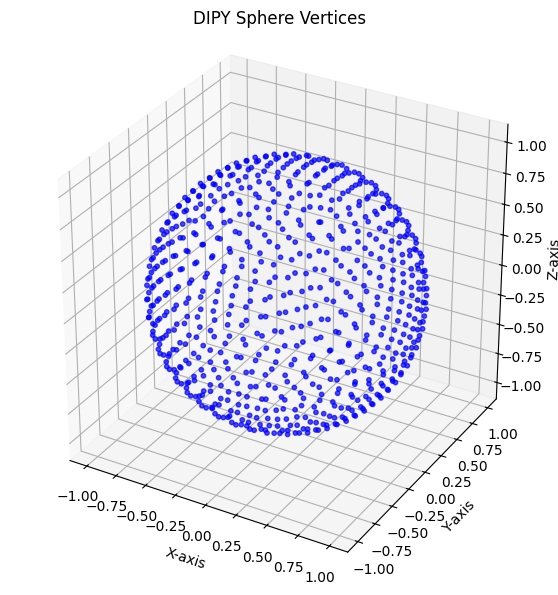

In [25]:
from mpl_toolkits.mplot3d import Axes3D

sphere = get_sphere('repulsion724')

#sphere = default_sphere

# Extract the sphere vertices (X, Y, Z coordinates)
x, y, z = sphere.vertices.T  # Transpose to separate coordinates

# Create a 3D scatter plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere vertices
ax.scatter(x, y, z, color='b', s=10, alpha=0.7)

# Set labels and aspect ratio
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("DIPY Sphere Vertices")
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

# Show plot
plt.show()

# **Ways to Quantify Directional diffusion**

### Quantify Longitudinal Vs Transverse Diffusion: ### 
🔹 Interpretation
- Ratio > 1 → More diffusion in the transverse plane (potential sign of demyelination or pathology).
- Ratio < 1 → More diffusion along the spinal cord (healthy white matter typically shows this).
- Ratio ≈ 1 → Balanced diffusion between transverse and longitudinal planes.

In [26]:
### Quantify Longitudinal Vs Transverse Diffusion: ### 

# Extract sphere vertices (unit vectors representing different diffusion directions)
vertices = sphere.vertices  # Shape: (N, 3), where N is the number of directions

# Define transverse vs. longitudinal directions
longitudinal_mask = np.abs(vertices[:, 2]) > 0.45  # High Z component = longitudinal
transverse_mask = ~longitudinal_mask  # Remaining directions are transverse

# Example voxel coordinate (replace with loop for all voxels)
voxel_coords = (40, 40, 10)

# Extract ODF values for the voxel
odf_values = csaodfs[voxel_coords]  # ODF values for the selected voxel

# Compute total diffusion in each plane
transverse_diffusion = np.sum(odf_values[transverse_mask])
longitudinal_diffusion = np.sum(odf_values[longitudinal_mask])

# Compute ratio of transverse to longitudinal diffusion
ratio = transverse_diffusion / (longitudinal_diffusion + 1e-8)  # Avoid division by zero

print(f"Voxel {voxel_coords}:")
print(f"  Transverse diffusion: {transverse_diffusion:.4f}")
print(f"  Longitudinal diffusion: {longitudinal_diffusion:.4f}")
print(f"  Transverse/Longitudinal Ratio: {ratio:.4f}")


NameError: name 'csaodfs' is not defined

# **FINAL MODELS**

In [2]:
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)

# DTI DATA 
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
DTI_combined_preproc_trans_masked_rotated.shape

KeyboardInterrupt: 

## **Model Every Slice Individually Correcting for Rotation**

C:\Users\sigur\AppData\Local\Temp\ipykernel_40920\327852113.py:24: UserWarning: Pass ['bvecs'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  gtab = gradient_table(bvals, bvecs)


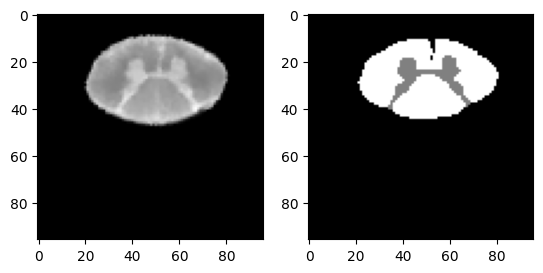

In [3]:
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)

# DTI DATA 
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
DTI_combined_preproc_trans_masked_rotated.shape

# Plot
z = 100
plt.subplot(1, 2, 1)
plt.imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z,0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(mask_gm_wm[:, :, z], cmap='gray')


#bvecs and bvals
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

rotation_data = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/complete_coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

In [ ]:
# Load in Data
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
DTI_combined_preproc_trans_masked , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/DTI_combined_preproc_trans_masked.nii.gz")


## Load GM Mask 



gm_mask = np.load("Combined_Data/Rotated and Transposed/GM_mask_aug_rotated_100epoch_f1_threshold.npy")
gm_mask = np.transpose(gm_mask, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
gm_mask_resized = scipy.ndimage.zoom(gm_mask, (96/200, 96/200, 1, 1), order=1)  # Bilinear interpolation


DTI_combined_preproc_trans_masked_GM = gm_mask_resized * DTI_combined_preproc_trans_masked_rotated

#bvecs and bvals
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

rotation_data = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/complete_coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

In [19]:
bvecs_bvals = np.hstack([bvecs, bvals.reshape(-1, 1)])
np.savetxt('AMICO/scheme.scheme', bvecs_bvals)

print(bvecs_bvals.shape)


(83, 4)


### Check Rotation and Rotate Bvecs Accordingly

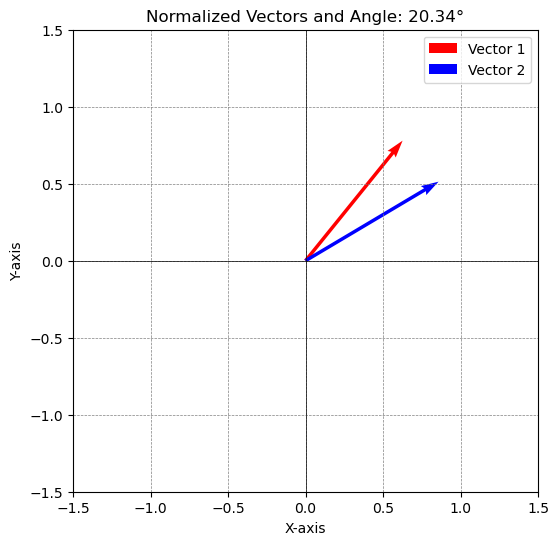

In [7]:
# Function to plot a vector line
def plot_vector(x1, y1, x2, y2):
    # Normalize the vectors
    magnitude1 = (x1**2 + y1**2)**0.5
    magnitude2 = (x2**2 + y2**2)**0.5
    x1, y1 = x1 / magnitude1, y1 / magnitude1
    x2, y2 = x2 / magnitude2, y2 / magnitude2

    plt.figure(figsize=(6, 6))
    plt.quiver(0, 0, x1, y1, angles='xy', scale_units='xy', scale=1, color='r', label='Vector 1')
    plt.quiver(0, 0, x2, y2, angles='xy', scale_units='xy', scale=1, color='b', label='Vector 2')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    # Calculate the angle between the two vectors
    dot_product = x1 * x2 + y1 * y2
    angle_rad = np.arccos(dot_product)  # Magnitudes are 1, so no need to divide
    angle_deg = np.degrees(angle_rad)
    
    plt.title(f"Normalized Vectors and Angle: {angle_deg:.2f}°")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()



z  = 129 
idx = np.argwhere(rotation_data["z"] == z)[0][0] #Get the index of the slice

angle_degrees = -rotation_data[idx]["smoothed_angle"]  # Extract the angle in degrees from the dictionary
angle_rad = np.deg2rad(angle_degrees)

# Define 3D rotation matrix for Z-axis (XY-plane)
rotation_matrix = np.array([
    [np.cos(angle_rad), np.sin(angle_rad), 0],
    [-np.sin(angle_rad),  np.cos(angle_rad), 0],
    [0,                 0,                  1]
    ])

rotated_bvec = bvecs @ rotation_matrix.T

# Test Bvecs Rotation
bvecs_idx = 3


plot_vector(x1 = bvecs[bvecs_idx][0], y1 = bvecs[bvecs_idx][1], 
            x2 = rotated_bvec[bvecs_idx][0],y2=rotated_bvec[bvecs_idx][1])

In [8]:
##### Plot the difference and proceudre of rotation #####
RARE_combined_masked, RARE_affine_all = load_nifti("Combined_Data/Transposed/RARE_combined_trans_masked.nii.gz")
RARE_rotated_combined_masked, RARE_affine_all = load_nifti("Combined_Data/Rotated and Transposed/RARE_combined_trans_masked_rotated.nii.gz")

# Resize RARE data to match DTI dimensions
RARE_rotated_combined_resized = scipy.ndimage.zoom(RARE_rotated_combined_masked, (96/RARE_rotated_combined_masked.shape[0], 96/RARE_rotated_combined_masked.shape[1], 1), order=1)  # Bilinear interpolation

import cv2
z  = 129 
idx = np.argwhere(rotation_data["z"] == z)[0][0] #Get the index of the slice

#unit8
image = RARE_combined_masked[:,:,z]
image_uint8 = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
image_rotated = RARE_rotated_combined_masked[:,:,z]
image_rotated_uint8 = ((image_rotated - np.min(image_rotated)) / (np.max(image_rotated) - np.min(image_rotated)) * 255).astype(np.uint8)

image_resized = cv2.resize(image_uint8, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
image_resized_rotated = cv2.resize(image_rotated_uint8, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)


# Draw a red line on the first image
start_point = tuple(rotation_data[idx]["start"])
end_point = tuple(rotation_data[idx]["end"])
image_with_line = cv2.line(image_resized.copy(), start_point, end_point, color=(0, 0, 255), thickness=2)

# Draw a blue line on the second image (if needed, uncomment the next line)
# image_with_line_rotated = cv2.line(image_resized_rotated_uint8.copy(), (482, 287), (524, 309), color=(255, 0, 0), thickness=2)

# Combine the two images side by side
combined_image = cv2.hconcat([image_with_line, image_resized_rotated])

# Display the combined image
cv2.imshow("Original and Rotated Data", combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
margin = 10 # Define the margin for cropping
def get_nonzero_bounds(volume):
    # Assumes 3D input: (x, y, z)
    nonzero = np.nonzero(volume)
    x_min, x_max = np.min(nonzero[0]), np.max(nonzero[0])
    y_min, y_max = np.min(nonzero[1]), np.max(nonzero[1])
    z_min, z_max = np.min(nonzero[2]), np.max(nonzero[2])
    return (x_min, x_max, y_min, y_max, z_min, z_max)

x_min, x_max, y_min, y_max, z_min, z_max = get_nonzero_bounds(RARE_rotated_combined_resized)
# Adjust the bounds to include the margin
x_min = max(0, x_min - margin)
x_max = min(RARE_rotated_combined_resized.shape[0] - 1, x_max + margin)
y_min = max(0, y_min - margin)
y_max = min(RARE_rotated_combined_resized.shape[1] - 1, y_max + margin)
# Crop the image using the adjusted bounds

cropped_data = RARE_rotated_combined_resized[x_min:x_max, y_min:y_max,:]

In [10]:
napari.view_image(cropped_data, ndisplay=3)

Viewer(camera=Camera(center=(41.5, 47.0, 982.0), zoom=0.3872519083969465, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(41.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=3, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=83.0, step=1.0), RangeTuple(start=0.0, stop=94.0, step=1.0), RangeTuple(start=0.0, stop=1964.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(41.0, 47.0, 982.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'cropped_data' at 0x252cc211100>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[<function double_click_to_zoom at 0x00000252C0BF6160>], mous

### Start modelling

In [21]:
GFA_slices = np.zeros((96,96,DTI_combined_preproc_trans_masked_rotated.shape[2]))

In [ ]:
######### Model 1 #########

####  Extract GFA for each slice ####
GFA_slices = np.zeros((96,96,DTI_combined_preproc_trans_masked_rotated.shape[2]))

for z in range(DTI_combined_preproc_trans_masked_rotated.shape[2]):
    if z % 100 == 0:
        print(f"starting: z = {z}")
    
    idx = np.argwhere(rotation_data["z"] == z)[0][0] #Get the index of the slice
    angle_degrees = -rotation_data[idx]["smoothed_angle"]  # Extract the angle in degrees from the dictionary
    angle_rad = np.deg2rad(angle_degrees)

    # Define 3D rotation matrix for Z-axis (XY-plane)
        rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad),  np.cos(angle_rad), 0],
        [0,                 0,                  1]
        ])

    rotated_bvec = bvecs @ rotation_matrix.T
    gtab_rotated = gradient_table(bvals, rotated_bvec)

    #subset data
    data_temp = np.expand_dims(DTI_combined_preproc_trans_masked_rotated[:,:,z,:], axis=2)
    mask = np.expand_dims(gm_mask_resized[:,:,z,0], axis=2)

    #Get Sphere
    sphere = get_sphere("symmetric642")

    csamodel = CsaOdfModel(gtab_rotated, 8)
    model = csamodel.fit(data_temp, mask=mask)

    GFA_slices[:,:,z] = model.gfa.squeeze()
    np.save("Results/GFA_slices_rotated.npy", GFA_slices)

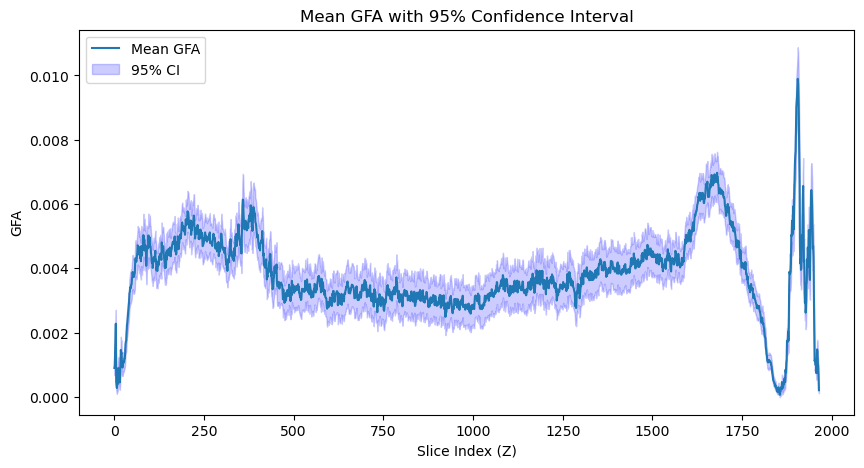

In [62]:
# Calculate mean and standard error of the mean (SEM) of GFA for each slice (over x and y axes)
mean_gfa = np.mean(GFA_slices, axis=(0, 1))
sem_gfa = np.std(GFA_slices, axis=(0, 1), ddof=1) / np.sqrt(GFA_slices.shape[0] * GFA_slices.shape[1])

import matplotlib.pyplot as plt

ci_factor = 1.96  # For 95% confidence interval
lower_bound = mean_gfa - ci_factor * sem_gfa
upper_bound = mean_gfa + ci_factor * sem_gfa

plt.figure(figsize=(10, 5))
plt.plot(mean_gfa, label='Mean GFA')
plt.fill_between(np.arange(len(mean_gfa)), lower_bound, upper_bound, color='b', alpha=0.2, label='95% CI')
plt.xlabel('Slice Index (Z)')
plt.ylabel('GFA')
plt.title('Mean GFA with 95% Confidence Interval')
plt.legend()
plt.show()


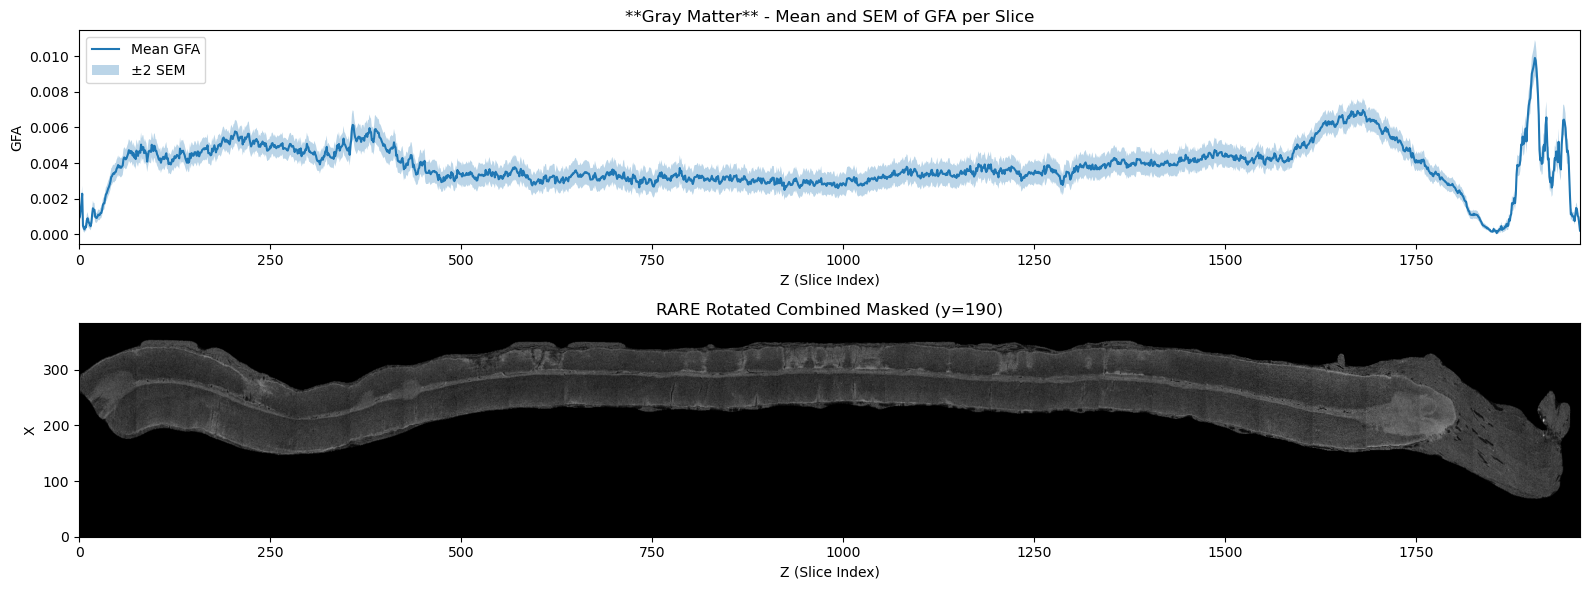

In [66]:
# Calculate mean and standard error of the mean (SEM) of GFA for each slice (over x and y axes)
mean_gfa = np.mean(GFA_slices, axis=(0, 1))
sem_gfa = np.std(GFA_slices, axis=(0, 1), ddof=1) / np.sqrt(GFA_slices.shape[0] * GFA_slices.shape[1])



z_len = RARE_rotated_combined_masked.shape[2]  # Length of Z (number of slices)

fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

# Top: Mean GFA plot
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_gfa, label='Mean GFA')
ax1.fill_between(np.arange(len(mean_gfa)), mean_gfa - 2*sem_gfa, mean_gfa + 2*sem_gfa, alpha=0.3, label='±2 SEM')
ax1.set_xlabel('Z (Slice Index)')
ax1.set_ylabel('GFA')
ax1.set_title('**Gray Matter** - Mean and SEM of GFA per Slice')
ax1.set_xlim([0, z_len - 1])  # Ensure axis limits match
ax1.legend()

# Bottom: Anatomical image (y=190)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(RARE_rotated_combined_masked[:,190,:], cmap='gray', aspect='auto',
           extent=[0, z_len - 1, 0, RARE_rotated_combined_masked.shape[0]])  # Set extent for matching x
ax2.set_title('RARE Rotated Combined Masked (y=190)')
ax2.set_xlabel('Z (Slice Index)')
ax2.set_ylabel('X')

plt.tight_layout()
plt.show()

In [ ]:
########## Extract Peak directions ################# and values and plot for each slice:
for z in np.arange(1230,DTI_combined_preproc_trans_masked_rotated.shape[2]): #range(DTI_combined_preproc_trans_masked_rotated.shape[2]):
    if z % 100 == 0:
        print(f"starting: z = {z}")
    
    idx = np.argwhere(rotation_data["z"] == z)[0][0] #Get the index of the slice
    angle_degrees = -rotation_data[idx]["smoothed_angle"]  # Extract the angle in degrees from the dictionary
    angle_rad = np.deg2rad(angle_degrees)

    # Define 3D rotation matrix for Z-axis (XY-plane)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad),  np.cos(angle_rad), 0],
        [0,                 0,                  1]
        ])

    rotated_bvec = bvecs @ rotation_matrix.T
    gtab_rotated = gradient_table(bvals, rotated_bvec)

    #subset data
    data_temp = np.expand_dims(DTI_combined_preproc_trans_masked_rotated[:,:,z,:], axis=2)
    mask = np.expand_dims(gm_mask_resized[:,:,z,0], axis=2)

    #Get Sphere
    sphere = get_sphere("symmetric362")

    csamodel = CsaOdfModel(gtab_rotated, 8)
    csafit = csamodel.fit(data_temp)
    sphere = get_sphere('symmetric362')  # 362-point symmetric spher
    fODF = csafit.odf(sphere)

    plt.imshow(csafit.gfa)


    # Plotting the ODF
    csapeaks = peaks_from_model(
        model=csamodel,
        data=data_temp,
        sphere= sphere,
        relative_peak_threshold=0.5,
        min_separation_angle=15,
        npeaks = 10,
        mask=mask,
        return_odf=False,
        normalize_peaks=True,
    )


    # Plot and save ODF
    scene = window.Scene()
    scene.background([1.0, 1.0, 1.0]) # Set background color to white
    b0_image = np.expand_dims(cropped_data[:,:,z], axis=2)
    #b0_image = np.expand_dims(RARE_rotated_combined_resized[10:50,20:90,z], axis=2)



    #B0 Actor
    b0_actor = actor.slicer(b0_image) 
    b0_actor.RotateZ(90)  # Rotate the B0 image to match the ODF orientation
    b0_actor.display(z = 0)
    b0_actor.SetPosition(0, 0, -.5)  # Negative value puts it behind the ODFs


    #ODF Actor
    fodf_peaks = actor.peak_slicer(csapeaks.peak_dirs, peaks_values = csapeaks.peak_values, colors = None )
    fodf_peaks.RotateZ(90)

    #Text
    title_text = actor.text_3d(f"Z-slice =  {z} ", position = (-70,50,2), font_size= 5)

    #Add to Scene
    scene.add(title_text)
    scene.add(fodf_peaks)
    scene.add(b0_actor)

    output_name = os.path.join("figures/peaks_odf_rotated_final", f"zslice_{z}.png")
    scene.reset_camera()
    window.record(scene=scene, n_frames=1, out_path=output_name, size=(1080, 1080), magnification= 2, screen_clip= True)  


In [ ]:
############### Extract ODF ################# and plot + save for each slice:
for z in np.arange(1244,DTI_combined_preproc_trans_masked_rotated.shape[2]):#range(DTI_combined_preproc_trans_masked_rotated.shape[2]):
    if z % 100 == 0:
        print(f"starting: z = {z}")
    
    idx = np.argwhere(rotation_data["z"] == z)[0][0] #Get the index of the slice
    angle_degrees = -rotation_data[idx]["smoothed_angle"]  # Extract the angle in degrees from the dictionary
    angle_rad = np.deg2rad(angle_degrees)

    # Define 3D rotation matrix for Z-axis (XY-plane)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad),  np.cos(angle_rad), 0],
        [0,                 0,                  1]
        ])

    rotated_bvec = bvecs @ rotation_matrix.T
    gtab_rotated = gradient_table(bvals, rotated_bvec)

    #subset data
    data_temp = np.expand_dims(DTI_combined_preproc_trans_masked_rotated[:,:,z,:], axis=2)
    mask = np.expand_dims(gm_mask_resized[:,:,z,0], axis=2)

    #Get Sphere
    sphere = get_sphere("symmetric362")

    csamodel = CsaOdfModel(gtab_rotated, 6)
    #csamodel.fit()
    csapeaks_temp = peaks_from_model(
        model = csamodel,
        mask = mask,
        data = data_temp,
        sphere= sphere,
        relative_peak_threshold= 0.3,
        min_separation_angle= 25,
        return_odf=True,
        normalize_peaks=True,
    )


    #clip the ODF 
    csaodfs = np.clip(csapeaks_temp.odf, 0, np.max(csapeaks_temp.odf, -1)[..., None])
    csaodfs = csaodfs[x_min:x_max, y_min:y_max,:]
  

    GFA = csapeaks_temp.gfa


    ##### Save ODF #####
    scene = window.Scene()

    # Plot and save ODF
    scene = window.Scene()
    scene.background([1.0, 1.0, 1.0]) # Set background color to white
    b0_image = np.expand_dims(cropped_data[:,:,z], axis=2)
    #b0_image = np.expand_dims(RARE_rotated_combined_resized[10:50,20:90,z], axis=2)



    #B0 Actor
    b0_actor = actor.slicer(b0_image) 
    b0_actor.RotateZ(90)  # Rotate the B0 image to match the ODF orientation
    b0_actor.display(z = 0)
    b0_actor.SetPosition(0, 0, -.5)  # Negative value puts it behind the ODFs

    #ODF Actor
    #csaodfs = np.rot90(csaodfs, k=1, axes=(0, 1))
    csa_odfs_actor = actor.odf_slicer(
        csaodfs, sphere=sphere, colormap="plasma", scale=.5)
    csa_odfs_actor.RotateZ(90)
    csa_odfs_actor.display(z= 0)

    #Text
    title_text = actor.text_3d(f"Z-slice =  {z} ", position = (-70,50,2), font_size= 5)

    #Add to Scene
    scene.add(title_text)
    scene.add(csa_odfs_actor)
    scene.add(b0_actor)

    output_name = os.path.join("figures/csa_odf_rotated_final", f"zslice_{z}.png")
    scene.reset_camera()
    window.record(scene=scene, n_frames=1, out_path=output_name, size=(1080, 1080), magnification= 2, screen_clip= True)  

    #window.show(scene)

starting: z = 1300
starting: z = 1400
starting: z = 1500
starting: z = 1600
starting: z = 1700
starting: z = 1800
starting: z = 1900


In [ ]:
############# Make video:  #######################

import cv2
import os
import re

from natsort import natsorted


# Path to the folder with your images
image_folder = 'figures/csa_odf_rotated_final'  # Replace with your actual path
output_video = 'figures/zslice_movie.mp4'
frame_rate = 10  # You can adjust this

# Get and naturally sort all .png images
images = [img for img in os.listdir(image_folder) if img.endswith('.png')]
sorted_images = natsorted(images)

# Load the first image to get frame size
first_frame = cv2.imread(os.path.join(image_folder, sorted_images[0]))
height, width, layers = first_frame.shape

# Create the video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

# Write each image to the video
for img_name in sorted_images:
    frame = cv2.imread(os.path.join(image_folder, img_name))
    video.write(frame)

video.release()
print(f"Video saved as {output_video}")



Video saved as figures/zslice_movie.mp4


# **Model Combined Preprocessed Rotated Data**

In [ ]:
# Load in Data
dwMRI_corrected = ants.image_read("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated_BFC_corrected20.nii.gz")
dwMRI, affine = load_nifti("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
t2_corrected = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
print(f"shape of dwMRI: {dwMRI_corrected.shape}")
print(f"shape of T2: {t2_corrected.shape}")

## Load Final Mask:::
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)

shape of dwMRI: (96, 96, 1965, 83)
shape of T2: (384, 384, 1965)


In [ ]:

## Load 100 epoch mask
# GM
gm_mask_100epoch = np.load("Combined_Data/Rotated and Transposed/GM_mask_aug_rotated_100epoch_f1_threshold.npy")
gm_mask_100epoch = np.transpose(gm_mask_100epoch, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
gm_mask_100epoch_resized = scipy.ndimage.zoom(gm_mask_100epoch, (96/200, 96/200, 1, 1), order=0)  # Nearest-neighbor interpolation

# WM 
wm_mask_100epoch = np.load("Combined_Data/Rotated and Transposed/WM_mask_rotated_augmented_100epoch_f1_threshold.npy")
wm_mask_100epoch = np.transpose(wm_mask_100epoch, (1,2, 0,3))
# Resize the WM mask to match DTI image dimensions
wm_mask_100epoch_resized = scipy.ndimage.zoom(wm_mask_100epoch, (96/200, 96/200, 1, 1), order=0)  # Nearest-neighbor interpolation


NameError: name 'mask_gm_wm' is not defined

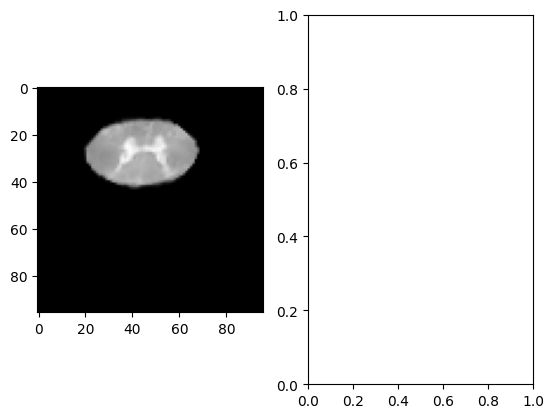

In [ ]:
z = 500
plt.subplot(1, 3, 1)
plt.imshow(dwMRI_corrected.numpy()[:,:,z,0], cmap = "gray")

plt.subplot(1,3,2)
plt.imshow(t2_corrected.numpy()[:,:,z], cmap = "gray")

plt.subplot(1, 3, 2)
plt.imshow(mask_gm_wm[:,:,z,0], cmap = "gray", alpha=0.3)

In [ ]:
for z in np.arange(0, dwMRI_corrected.shape[2], 5):
    plt.imshow(dwMRI_corrected.numpy()[:,:,z,0], cmap = "gray")
    plt.imshow(gm_mask_100epoch_resized[:,:,z,0], cmap = "gray", alpha=0.3)
    plt.show()
    IPython.display.clear_output(wait=True)
    plt.close()                                          
    

In [ ]:
# Load in Data
#DTI_combined_preproc_trans_flipped_masked , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_flipped_masked.nii.gz")
#DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_masked_rotated.nii.gz")
DTI_combined_preproc_trans_masked , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_masked.nii.gz")


## Load 20 Epoch Mask
gm_mask = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/GM_mask.npy")
gm_mask = np.transpose(gm_mask, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
gm_mask_resized = scipy.ndimage.zoom(gm_mask, (96/200, 96/200, 1, 1), order=1)  # Bilinear interpolation

## Load 50 epoch mask
gm_mask_50epoch = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/GM_mask_50epoch.npy")
gm_mask_50epoch = np.transpose(gm_mask_50epoch, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
gm_mask_50epoch_resized = scipy.ndimage.zoom(gm_mask, (96/200, 96/200, 1, 1), order=1)  # Bilinear interpolation


DTI_combined_preproc_trans_masked_GM = gm_mask_resized * DTI_combined_preproc_trans_masked

DTI_combined_preproc_trans_masked_GM_50epoch = gm_mask_50epoch_resized * DTI_combined_preproc_trans_masked

#bvecs and bvals
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [ ]:
## PLot the data, mask, overlay, and masked data
for z in np.arange(0,DTI_combined_preproc_trans_masked.shape[2], 4):
    if keyboard.is_pressed('esc'):
        print("Exiting loop...")
        break

    fig, axes = plt.subplots(2, 4, figsize=(15, 5))

    axes[0,0].imshow(DTI_combined_preproc_trans_masked[:, :, z, 0], cmap="gray")
    axes[0,0].set_title("DTI Masked")

    axes[0,1].imshow(gm_mask_resized[:, :, z, 0])
    axes[0,1].set_title("GM Mask Resized")

    axes[0,2].imshow(DTI_combined_preproc_trans_masked[:, :, z, 0], cmap="gray")
    axes[0,2].imshow(gm_mask_resized[:, :, z, 0], alpha=0.5)
    axes[0,2].set_title("Overlay")

    axes[0,3].imshow(DTI_combined_preproc_trans_masked_GM[:, :, z, 0], cmap="gray")
    axes[0,3].set_title("GM Masked Data")

    axes[1,0].imshow(DTI_combined_preproc_trans_masked[:, :, z, 0], cmap="gray")
    axes[1,0].set_title("DTI Masked 50 Epoch")

    axes[1,1].imshow(gm_mask_50epoch_resized[:, :, z, 0])
    axes[1,1].set_title("GM Mask Resized 50 Epoch")

    axes[1,2].imshow(DTI_combined_preproc_trans_masked[:, :, z, 0], cmap="gray")
    axes[1,2].imshow(gm_mask_50epoch_resized[:, :, z, 0], alpha=0.5)
    axes[1,2].set_title("Overlay 50 Epoch")

    axes[1,3].imshow(DTI_combined_preproc_trans_masked_GM_50epoch[:, :, z, 0], cmap="gray")
    axes[1,3].set_title("GM Masked Data 50 Epoch")

    plt.subplots_adjust(hspace=0.4)  # Adjust the hspace parameter to increase the distance between rows
    #plt.show()

    display(fig)
    IPython.display.clear_output(wait=True)

In [ ]:
z_axis = 400
bvec = 0

#Plotting
plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Z-Slice = {z_axis} and Bvec = {bvec}")

axes[0].imshow(DTI_combined_preproc_trans_flipped_masked[:, :, z_axis, bvec], cmap="gray")
axes[0].set_title("Transposed + Flipped + Masked")
axes[0].invert_yaxis()

axes[1].imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z_axis, bvec], cmap="gray")
axes[1].set_title("Transposed + Masked + Rotated")
axes[1].invert_yaxis()

axes[2].imshow(DTI_combined_preproc_trans_masked[:, :, z_axis, bvec], cmap="gray")
axes[2].set_title("Transposed + Masked")
axes[2].invert_yaxis()

plt.show()


## Tenfit Model

C:\Users\sigur\AppData\Local\Temp\ipykernel_12588\1096670203.py:28: UserWarning: Pass ['bvecs'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  gtab = gradient_table(bvals, bvecs)


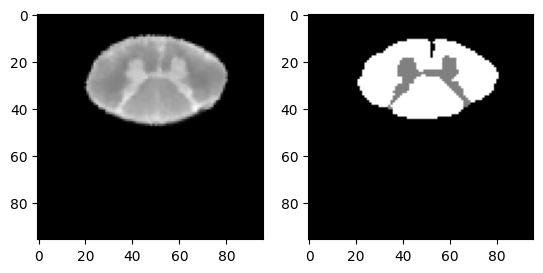

In [2]:
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)
mask_gm_wm = np.expand_dims(mask_gm_wm, axis=-1)

# Create separate masks for GM (gray matter) and WM (white matter)
mask_gm = (mask_gm_wm == 1)
mask_wm = (mask_gm_wm == 2)

# DTI DATA 
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")

# Plot
z = 100
plt.subplot(1, 2, 1)
plt.imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z,0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(mask_gm_wm[:, :, z], cmap='gray')


#bvecs and bvals
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

rotation_data = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/complete_coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

In [4]:
# (1) tensor fit Model
tenmodel_all = dti.TensorModel(gtab)


In [ ]:
# (2) Tensor Fitting
tenfit_all = tenmodel_all.fit(DTI_combined_preproc_trans_masked_rotated)

with open('Diffusion Models/tenfit_all_model.pkl', 'wb') as f:
    pickle.dump(tenfit_all, f)

In [ ]:
# (#) ODF fitting of DTI model
z_slice = 1500

#Get Sphere
sphere = get_sphere('repulsion724')
tensor_odfs = tenmodel_all.fit(DTI_combined_preproc_trans_masked_rotated[:,:, z_slice-1:z_slice], mask = mask_gm[:,:,z_slice-1:z_slice,0]).odf(sphere)


# Plot
scene = window.Scene()
odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None)
scene.add(odf_actor)

window.show(scene)

print("Saving illustration as tensor_odfs.png")
#window.record(scene=scene, n_frames=1, out_path="tensor_odfs.png", size=(600, 600))

C:\Users\sigur\AppData\Local\Temp\ipykernel_12588\1410601119.py:5: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  sphere = get_sphere('repulsion724')


Saving illustration as tensor_odfs.png


In [59]:
print("Computing tensor ellipsoids in a part of the splenium of the CC")

z_slice = 1000

FA = tenfit_all.fa
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit_all.evecs)


# Get spehre
sphere = get_sphere(name="repulsion724")

# Enables/disables interactive visualization
interactive = True

scene = window.Scene()

evals = tenfit_all.evals[:, :, z_slice:z_slice+1]
evecs = tenfit_all.evecs[:, :, z_slice:z_slice+1]

cfa = RGB[:, :, z_slice:z_slice+1]
cfa /= cfa.max()

scene.add(
    actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=1)
)

print("Saving illustration as tensor_ellipsoids.png")
window.record(
    scene=scene, n_frames=1, out_path="tensor_ellipsoids.png", size=(600, 600)
)
if interactive:
    window.show(scene)




Computing tensor ellipsoids in a part of the splenium of the CC


c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\fury\actor.py:1393: RuntimeWarning: invalid value encountered in cast
  ).astype("ubyte")


Saving illustration as tensor_ellipsoids.png


In [ ]:
tensor_vals = dti.lower_triangular(tenfit_all.quadratic_form)

C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\3857959825.py:12: RuntimeWarning: Mean of empty slice
  mean_FA_gm = np.nanmean(FA, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\3857959825.py:13: RuntimeWarning: Mean of empty slice
  mean_MD_gm = np.nanmean(MD, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\3857959825.py:14: RuntimeWarning: Mean of empty slice
  mean_AD_gm = np.nanmean(AD, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\3857959825.py:15: RuntimeWarning: Mean of empty slice
  mean_RD_gm = np.nanmean(RD, axis=(0, 1))


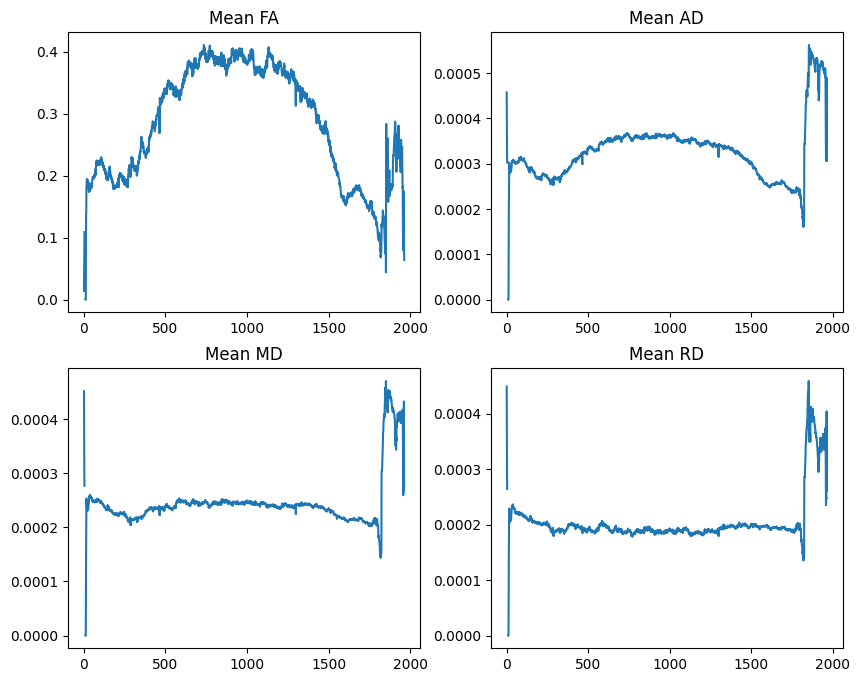

In [38]:
# Extract the standard diffusion parameters
FA = tenfit_all.fa
MD = tenfit_all.md
AD = tenfit_all.ad
RD = tenfit_all.rd

FA[mask_gm[:, :, :] == 0] = np.nan
MD[mask_gm[:, :, :] == 0] = np.nan
AD[mask_gm[:, :, :] == 0] = np.nan
RD[mask_gm[:, :, :] == 0] = np.nan

mean_FA_gm = np.nanmean(FA, axis=(0, 1))
mean_MD_gm = np.nanmean(MD, axis=(0, 1))
mean_AD_gm = np.nanmean(AD, axis=(0, 1))
mean_RD_gm = np.nanmean(RD, axis=(0, 1))

figure, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(mean_FA_gm, label='mean_FA_gm')
axes[0, 0].set_title("Mean FA")

axes[1, 0].plot(mean_MD_gm, label='mean_MD_gm')
axes[1, 0].set_title("Mean MD")

axes[0, 1].plot(mean_AD_gm, label='mean_AD_gm')
axes[0, 1].set_title("Mean AD")

axes[1, 1].plot(mean_RD_gm, label='mean_RD_gm')
axes[1, 1].set_title("Mean RD")

plt.show()

### **Diffusion Tensor Elements in DIPY**

The **diffusion tensor (D)** is a **3×3 symmetric matrix** representing diffusion along different directions:

\[
D = 
\begin{bmatrix}
D_{xx} & D_{xy} & D_{xz} \\
D_{xy} & D_{yy} & D_{yz} \\
D_{xz} & D_{yz} & D_{zz}
\end{bmatrix}
\]

Since **D** is symmetric, only **6 unique elements** are needed to describe it:

\[
(D_{xx}, D_{xy}, D_{yy}, D_{xz}, D_{yz}, D_{zz})
\]

## **Extracting the Diffusion Tensor Elements in DIPY**
After fitting the diffusion tensor model (`tenfit`), you can retrieve these elements using:

```python
tensor_elements = tenfit.lower_triangular()
Dxx = tensor_elements[..., 0]
Dxy = tensor_elements[..., 1]
Dyy = tensor_elements[..., 2]
Dxz = tensor_elements[..., 3]
Dyz = tensor_elements[..., 4]
Dzz = tensor_elements[..., 5]


guide: https://carpentries-incubator.github.io/SDC-BIDS-dMRI/instructor/diffusion_tensor_imaging.html


In [42]:
# Extract the lower triangular values of the tenfit model
tensor_elements = tenfit_all.lower_triangular()
Dxx = tensor_elements[..., 0]
Dxy = tensor_elements[..., 1]
Dyy = tensor_elements[..., 2]
Dxz = tensor_elements[..., 3]
Dyz = tensor_elements[..., 4]
Dzz = tensor_elements[..., 5]


Dxx[mask_gm[:, :, :] == 0] = np.nan
Dxy[mask_gm[:, :, :] == 0] = np.nan
Dyy[mask_gm[:, :, :] == 0] = np.nan
Dxz[mask_gm[:, :, :] == 0] = np.nan
Dyz[mask_gm[:, :, :] == 0] = np.nan
Dzz[mask_gm[:, :, :] == 0] = np.nan

mean_Dxx = np.nanmean(Dxx, axis=(0, 1))
mean_Dxy = np.nanmean(Dxy, axis=(0, 1))
mean_Dyy = np.nanmean(Dyy, axis=(0, 1))
mean_Dxz = np.nanmean(Dxz, axis=(0, 1))
mean_Dyz = np.nanmean(Dyz, axis=(0, 1))
mean_Dzz = np.nanmean(Dzz, axis=(0, 1))

std_Dxx = np.nanstd(Dxx, axis=(0, 1))
std_Dxy = np.nanstd(Dxy, axis=(0, 1))
std_Dyy = np.nanstd(Dyy, axis=(0, 1))
std_Dxz = np.nanstd(Dxz, axis=(0, 1))
std_Dyz = np.nanstd(Dyz, axis=(0, 1))
std_Dzz = np.nanstd(Dzz, axis=(0, 1))

C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\758997439.py:18: RuntimeWarning: Mean of empty slice
  mean_Dxx = np.nanmean(Dxx, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\758997439.py:19: RuntimeWarning: Mean of empty slice
  mean_Dxy = np.nanmean(Dxy, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\758997439.py:20: RuntimeWarning: Mean of empty slice
  mean_Dyy = np.nanmean(Dyy, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\758997439.py:21: RuntimeWarning: Mean of empty slice
  mean_Dxz = np.nanmean(Dxz, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\758997439.py:22: RuntimeWarning: Mean of empty slice
  mean_Dyz = np.nanmean(Dyz, axis=(0, 1))
C:\Users\sigur\AppData\Local\Temp\ipykernel_22640\758997439.py:23: RuntimeWarning: Mean of empty slice
  mean_Dzz = np.nanmean(Dzz, axis=(0, 1))
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 

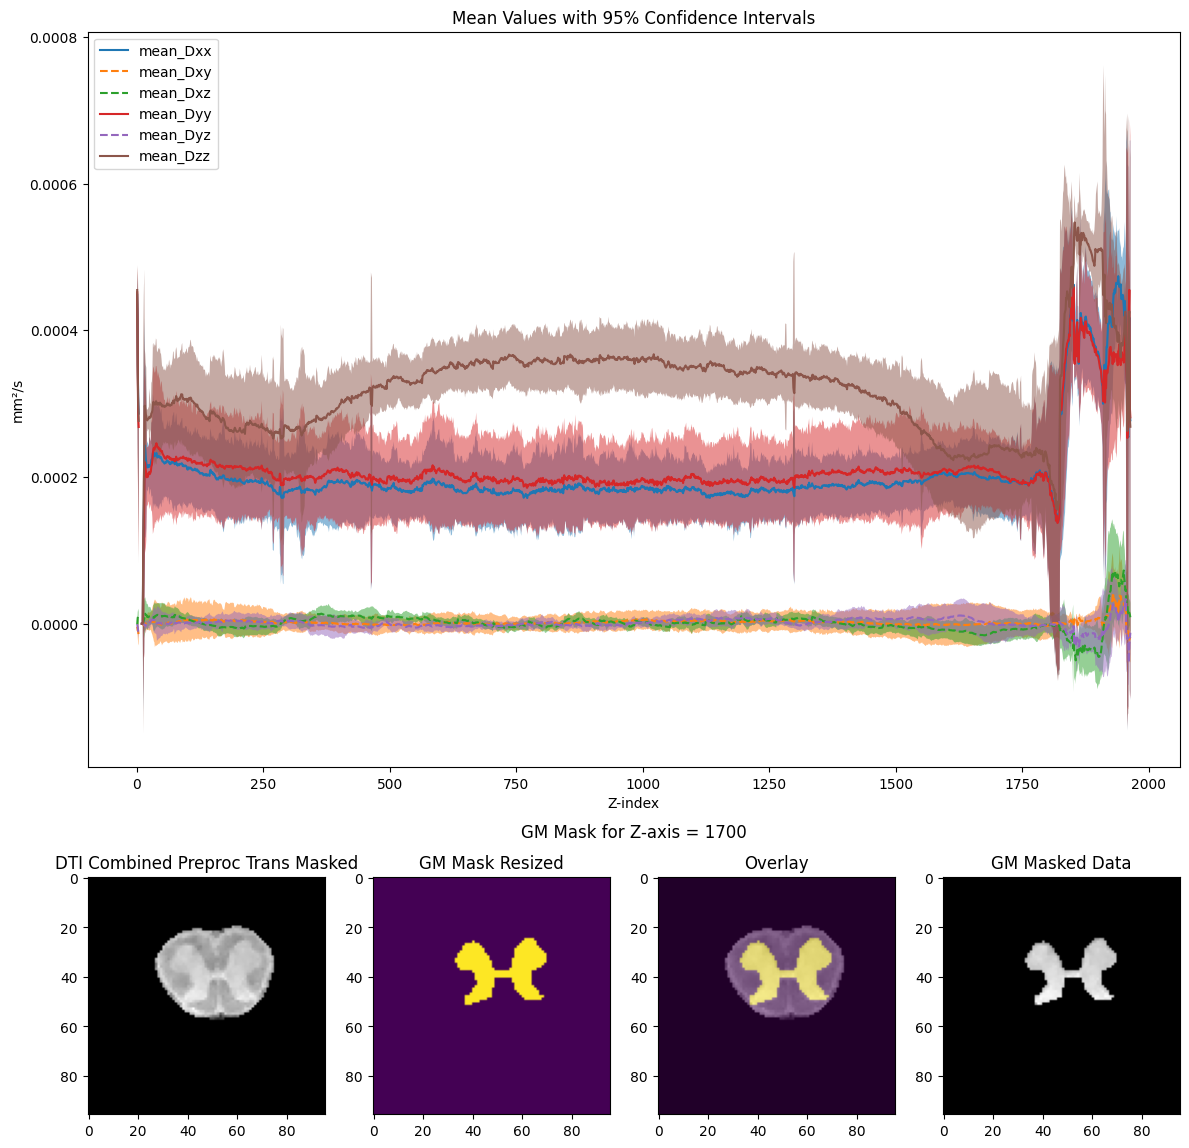

In [55]:

import matplotlib.gridspec as gridspec
z_axis = 1700


fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.01, .5])  # Reduce space for text row

# First plot (wide on top)
ax1 = plt.subplot(gs[0])
ci_factor = 1.96  # 95% confidence interval

mean_values = [mean_Dxx, mean_Dxy, mean_Dxz, mean_Dyy, mean_Dyz, mean_Dzz]
std_values = [std_Dxx, std_Dxy, std_Dxz, std_Dyy, std_Dyz, std_Dzz]
labels = ['mean_Dxx', 'mean_Dxy', 'mean_Dxz', 'mean_Dyy', 'mean_Dyz', 'mean_Dzz']
line_styles = ['-', '--', '--', '-', '--', '-']

for mean, std, label, line_style in zip(mean_values, std_values, labels, line_styles):
    ax1.plot(mean, label=label, linestyle=line_style)
    ax1.fill_between(range(len(mean)), mean - ci_factor * std, mean + ci_factor * std, alpha=0.5)

ax1.set_xlabel('Z-index')
ax1.set_ylabel('mm²/s')
ax1.set_title('Mean Values with 95% Confidence Intervals')
ax1.legend()

# Add text (aligned to top of second row)
ax_text = plt.subplot(gs[1])
ax_text.text(0.5, -6, f"GM Mask for Z-axis = {z_axis}", ha='center', fontsize=12)  # Align with top
ax_text.axis('off')

# Second plot (4 subplots below)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[2])

ax2 = plt.subplot(gs2[0])
ax2.imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z_axis, 0], cmap="gray")
ax2.set_title("DTI Combined Preproc Trans Masked")

ax3 = plt.subplot(gs2[1])
ax3.imshow(mask_gm[:, :, z_axis])
ax3.set_title("GM Mask Resized")

ax4 = plt.subplot(gs2[2])
ax4.imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z_axis, 0], cmap="gray")
ax4.imshow(mask_gm[:, :, z_axis], alpha=0.5)
ax4.set_title("Overlay")

ax5 = plt.subplot(gs2[3])
ax5.imshow(test[:, :, z_axis, 0], cmap="gray")
ax5.set_title("GM Masked Data")

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)  # Further reduce space between rows
plt.show()

# Save the plot as a PDF
fig.savefig("figures/Directional Diffusion ~ z-axis in gm.pdf", format='pdf')

## Q-ball Model:
Can't run wiht all the data at once needs 97gb of memory.

C:\Users\sigur\AppData\Local\Temp\ipykernel_12588\1096670203.py:28: UserWarning: Pass ['bvecs'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  gtab = gradient_table(bvals, bvecs)


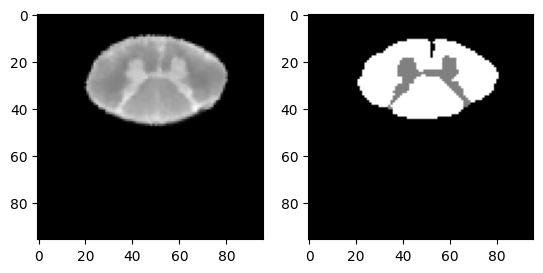

In [ ]:
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)
mask_gm_wm = np.expand_dims(mask_gm_wm, axis=-1)

# Create separate masks for GM (gray matter) and WM (white matter)
mask_gm = (mask_gm_wm == 1)
mask_wm = (mask_gm_wm == 2)

# DTI DATA 
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")

# Plot
z = 100
plt.subplot(1, 2, 1)
plt.imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z,0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(mask_gm_wm[:, :, z], cmap='gray')


#bvecs and bvals
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

rotation_data = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/complete_coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

In [ ]:
# (2) Q-ball HARDI Method
from dipy.reconst.shm import CsaOdfModel

#Get Sphere
sphere = get_sphere('repulsion724')

# Fragment the data into smaller chunks
chunk_size = 100  # Define the size of each chunk
num_chunks = DTI_combined_preproc_trans_masked_rotated.shape[2] // chunk_size + 1

# Initialize an empty list to store the results
csapeaks_list = []



for i in range(num_chunks):
    print(f"starting chunk = {i}")
    #Setup Model
    csamodel = CsaOdfModel(gtab, 8)

    #Find index for start and end of chunk:
    start_slice = i * chunk_size
    end_slice = min((i + 1) * chunk_size, DTI_combined_preproc_trans_masked_rotated.shape[2])
    
    # Extract the chunk of data
    data_chunk = DTI_combined_preproc_trans_masked_rotated[:, :, start_slice:end_slice]
    
    # Fit the model to the chunk of data
    csapeaks_chunk = peaks_from_model(
        model=csamodel,
        data=data_chunk,
        sphere=sphere,
        relative_peak_threshold=0.45,
        min_separation_angle=15,
        return_odf=True,
        normalize_peaks=True,
    )
    
    # Append the result to the list
    csapeaks_list.append(csapeaks_chunk)


starting chunk = 0
starting chunk = 1
starting chunk = 2
starting chunk = 3
starting chunk = 4
starting chunk = 5


MemoryError: Unable to allocate 4.97 GiB for an array with shape (96, 96, 100, 724) and data type float64

In [ ]:
# Combine the results from all chunks
csapeaks = csapeaks_list[0]
for csapeaks_chunk in csapeaks_list[1:]:
    csapeaks.peak_dirs = np.concatenate((csapeaks.peak_dirs, csapeaks_chunk.peak_dirs), axis=2)
    csapeaks.peak_values = np.concatenate((csapeaks.peak_values, csapeaks_chunk.peak_values), axis=2)
    csapeaks.odf = np.concatenate((csapeaks.odf, csapeaks_chunk.odf), axis=2)
    csapeaks.gfa = np.concatenate((csapeaks.gfa, csapeaks_chunk.gfa), axis=2)


GFA = csapeaks.gfa

print(f"GFA.shape {GFA.shape}")

#clip the ODF 
csaodfs = np.clip(csapeaks.odf, 0, np.max(csapeaks.odf, -1)[..., None])

# Model NON ROTATED COMBINED DATA

In [ ]:
# Load in Data
dwMRI_corrected = ants.image_read("Combined_Data/Transposed/DTI_combined_preproc_trans_masked_rotated_BFC_corrected20.nii.gz")
dwMRI, affine = load_nifti("Combined_Data/Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
t2_corrected = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
print(f"shape of dwMRI: {dwMRI_corrected.shape}")
print(f"shape of T2: {t2_corrected.shape}")

## Load Final Mask:::
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)




## DTI Model

# **Model Subset of Full Data**

In [ ]:
# Load in Data
#DTI_combined_preproc_trans_flipped_masked , DTI_Affine_all = load_nifti(Combined_Data/DTI_combined_preproc_trans_flipped_masked.nii.gz")
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
DTI_combined_preproc_trans_masked , DTI_Affine_all = load_nifti("Combined_Data/Transposed/DTI_combined_preproc_trans_masked.nii.gz")

## Spinal Cord Mask 
SCT_mask_trans = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/MASK_combined_trans.npy")

## Load 20 Epoch Mask
#gm_mask = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/GM_mask.npy")
#gm_mask = np.transpose(gm_mask, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
#gm_mask_resized = scipy.ndimage.zoom(gm_mask, (96/200, 96/200, 1, 1), order=1)  # Bilinear interpolation


#### Load 50 epoch mask
gm_mask = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/GM_mask_50epoch_f1_threshold.npy")
gm_mask = np.transpose(gm_mask, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
gm_mask_resized = scipy.ndimage.zoom(gm_mask, (96/200, 96/200, 1, 1), order=1)  # Bilinear interpolation


# GM + WM 
gm_wm_mask_50epoch, gm_mask_50epoch_affine = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/GM_WM_mask_50_epoch_f1_threshold.nii.gz")
gm_wm_mask_50epoch = np.transpose(gm_wm_mask_50epoch, (1,2, 0,3))
# Resize the GM mask to match DTI image dimensions
gm_wm_mask_50epoch_resized = scipy.ndimage.zoom(gm_wm_mask_50epoch, (96/200, 96/200, 1, 1), order=1)  # Bilinear interpolation



#Mask the Data using the GM mask
DTI_combined_preproc_trans_masked_GM_50epoch = gm_mask_resized * DTI_combined_preproc_trans_masked

#bvecs and bvals
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [3]:
#Subset of the data
z_sequence = np.arange(0, 1800, 20)
z_random = np.random.randint(100, 1800, size=100)
z_max = 400
z_min = 300

# Rotated and Flipped Data
#DTI_combined_preproc_trans_flipped_masked_subset = DTI_combined_preproc_trans_flipped_masked[:, :, z_min:z_max, :]

# Rotated Data
DTI_combined_preproc_trans_masked_rotated_subset = DTI_combined_preproc_trans_masked_rotated[:, :, z_sequence, :]

# Non Rotated Data 
DTI_combined_preproc_trans_masked_subset = DTI_combined_preproc_trans_masked[:, :,z_sequence, :]
DTI_combined_preproc_trans_masked_subset.shape


#Subet mask
SCT_mask_trans_subset = SCT_mask_trans[:, :, z_sequence]


gm_wm_mask_50epoch_resized_subset = gm_wm_mask_50epoch_resized[:, :, z_sequence, :]

We can Crop the Image as the last step before doing model fitting.

In [ ]:
#max_indx = DTI_combined_preproc_trans_masked_rotated.shape[3]  # Corrected to use the 4th dimension size

maskdata_rotation_subset, mask_rotation_subset = median_otsu(input_volume=  DTI_combined_preproc_trans_masked_rotated_subset, 
            vol_idx= np.arange(0, 2),  # Ensure vol_idx corresponds to valid indices along axis 3
            median_radius=2, 
            numpass=2, 
            autocrop=True)

In [27]:
print(mask_rotation_subset.shape)
maskdata_rotation_subset.shape

(50, 70, 90)


(50, 70, 90, 83)

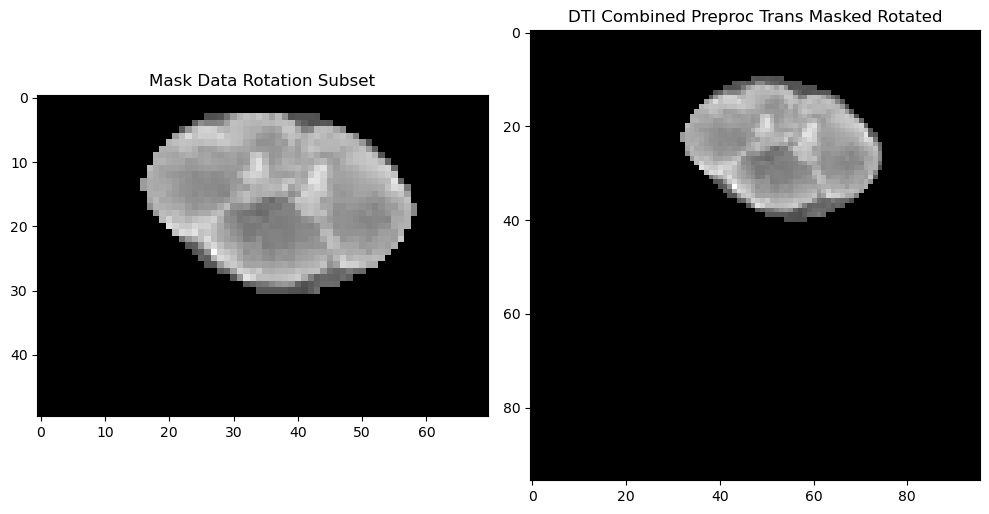

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(maskdata_rotation_subset[:, :, 40, 3], cmap='gray')
axes[0].set_title("Mask Data Rotation Subset")

axes[1].imshow(DTI_combined_preproc_trans_masked_subset[:, :, 40, 3], cmap='gray')
axes[1].set_title("DTI Combined Preproc Trans Masked Rotated")

plt.tight_layout()
plt.show()

In [ ]:
#Model (1) Tensor Model
tenmodel_subset = dti.TensorModel(gtab)


##### #Fit tenfit model to all 3 subsets ###
#tenfit_trans_flipped_masked_subset = tenmodel_subset.fit(DTI_combined_preproc_trans_flipped_masked_subset)

#tenfit_trans_masked_rotated_subset = tenmodel_subset.fit(DTI_combined_preproc_trans_masked_rotated_subset)

tenfit_DTI_trans_masked_subset = tenmodel_subset.fit(DTI_combined_preproc_trans_masked_subset)

#Plot the Model
plot_color_fa(tenfit_DTI_trans_masked_subset, ax_slice = 0)


<module 'fury.window' from 'c:\\Users\\Bruger\\anaconda3\\envs\\DIPY\\Lib\\site-packages\\fury\\window.py'>

In [ ]:
#Model(2): Reconstruct with Constant Solid Angle (Q-Ball) 

csamodel = CsaOdfModel(gtab,sh_order_max= 8)
sphere = get_sphere('repulsion724')

csapeaks = peaks_from_model(
    model= csamodel,
    data= DTI_combined_preproc_trans_masked_subset,
    sphere = sphere,
    mask = SCT_mask_trans_subset,
    relative_peak_threshold = 0.4, # Defines the minimum amplitude a peak must have relative to the highest peak in a voxel to be considered a valid fiber direction.
    min_separation_angle = 15,  # Defines the minimum angle between two peaks to consider them separate fiber directions.
    return_odf= True,
    normalize_peaks=True,
)
GFA = csapeaks.gfa
print(f"GFA.shape {GFA.shape}")

#clip the ODF 
csaodfs = np.clip(csapeaks.odf, 0, np.max(csapeaks.odf, -1)[..., None])


plot_ODF(data = DTI_combined_preproc_trans_masked_subset, 
        csaodfs= csaodfs,
        mask = None,
        interactive= False,
        save = True,
        save_path_folder= "figures/csa_odf_subset",
        z_increment = 20)

GFA.shape (96, 96, 90)


In [ ]:
#Model(2): Reconstruct with Constant Solid Angle (Q-Ball)    WITH ROTATED DATA

csamodel = CsaOdfModel(gtab,sh_order_max= 8)
sphere = get_sphere('repulsion724')

csapeaks_rotatated = peaks_from_model(
    model= csamodel,
    data = maskdata_rotation_subset,
    mask = mask_rotation_subset,
    sphere = sphere,
    relative_peak_threshold = 0.4, # Defines the minimum amplitude a peak must have relative to the highest peak in a voxel to be considered a valid fiber direction.
    min_separation_angle = 15,  # Defines the minimum angle between two peaks to consider them separate fiber directions.
    return_odf= True,
    normalize_peaks=True,
)
GFA_rotated = csapeaks_rotatated.gfa
print(f"GFA_rotated.shape {GFA_rotated.shape}")

#clip the ODF 
csaodfs_rotated = np.clip(csapeaks_rotatated.odf, 0, np.max(csapeaks_rotatated.odf, -1)[..., None])

GFA_rotated.shape (50, 70, 90)


In [20]:
def plot_ODF(data = None, csaodfs = None,mask = None, interactive = False, save = False, save_path_folder = None,z_increment = 20):

    scene = window.Scene()

    if mask != None:
        ## Masking of the Data and ODF
        mask_expanded = np.expand_dims(mask, axis=-1)  # Shape becom s (96, 96, 187, 1)
        # Apply the mask to data_subset
        data[~mask] = 0

    b0_image = data[:,:,:,0]

    #Rotate Data
    sphere = get_sphere('repulsion724')

    for z_slice in range(b0_image.shape[2]):
        #B0 Actor
        b0_actor = actor.slicer(b0_image) 
        b0_actor.display(z=z_slice)

        #ODF Actor 
        csa_odfs_actor = actor.odf_slicer(
            csaodfs, sphere=sphere, colormap="plasma", scale=0.4)
        csa_odfs_actor.display(z=z_slice)

        #Text
        title_text = actor.text_3d(f"Z-slice =  {z_slice*z_increment} ", position = (10,10,(z_slice+10)), font_size= 8)

        #Add to Scene
        scene.add(title_text)
        scene.add(csa_odfs_actor)
        scene.add(b0_actor)


        
        if os.path.isdir(save_path_folder):
            print("Folder exists")
        else:
            os.mkdir(save_path_folder)


        if save == True:
            print(f"Saving illustration as zslice_{z_slice*z_increment}.png")
            output_name = os.path.join(save_path_folder, f"zslice_{z_slice*z_increment}.png")
            window.record(scene=scene, n_frames=1, out_path=output_name, size=(3080, 3080), magnification= 2, screen_clip= True)
        

        #Show it 
        if interactive == True:
            window.show(scene)
            while True:
                if keyboard.is_pressed('space'):        
                    print("Continuing...") 
                    #plt.close('all')  # Close all matplotlib plots
                    IPython.display.clear_output(wait=True)
                    time.sleep(0.05)  # Small delay to avoid multiple triggers
                    break

        scene.clear()

In [ ]:
plot_ODF(data = maskdata_rotation_subset, 
        csaodfs= csaodfs_rotated,
        mask = None,
        interactive= False,
        save = True,
        save_path_folder= "figures/csa_odf_rotated_subset",
        z_increment = 20)

# Run models with full Data

In [4]:
#Model (1) Tensor Model
DTI_combined_masked , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_flipped_masked.nii.gz")
print(DTI_combined_masked.shape)

tenmodel_all = dti.TensorModel(gtab)
tenfit_all = tenmodel_all.fit(DTI_combined_masked)

(96, 96, 1965, 83)


In [ ]:
#Model (1) Tensor Model
plot_color_fa(tenfit_all, ax_slice = -300)

<module 'fury.window' from 'c:\\Users\\Bruger\\anaconda3\\envs\\DIPY\\Lib\\site-packages\\fury\\window.py'>

In [ ]:
#Model(2): Reconstruct with Constant Solid Angle (Q-Ball)

#load data
DTI_combined_trans , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_flipped.nii.gz")
mask_trans = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/MASK_combined_trans.npy")

In [ ]:
#Model(2): Reconstruct with Constant Solid Angle (Q-Ball)

#Subset Data & Mask 
z_slices_subset = np.arange(0,DTI_combined_trans.shape[2], step = 10) # Z_slices

data_subset = DTI_combined[:,:,z_slices_subset,:]
mask_subset = mask_trans[:,:,z_slices_subset]

from dipy.reconst.shm import CsaOdfModel

csamodel = CsaOdfModel(gtab, 8)

csapeaks = peaks_from_model(
    model= csamodel,
    data= data_subset,
    sphere= default_sphere,
    relative_peak_threshold=0.5,
    min_separation_angle= 15,
    mask = mask_subset,
    return_odf= True,
    normalize_peaks=True,
)

GFA = csapeaks.gfa

print(f"GFA.shape {GFA.shape}")

#clip the ODF 
csaodfs = np.clip(csapeaks.odf, 0, np.max(csapeaks.odf, -1)[..., None])

GFA.shape (96, 96, 197)


In [ ]:
## ODF 
mask_all = np.load('C:/DTI_SC/humanSC_400h/Combined_Data/MASK_combined.npy')

#ODF Construction
sphere = get_sphere('repulsion724')
tensor_odfs = tenfit_all.odf(sphere = sphere)

tensor_odfs_masked = tensor_odfs[mask_all,:] #Turn all values outside of mask into False
tensor_odfs[mask_all == False] = 0 # Turn false into 0's.


#Plot and save ODF 
interactive = True #False = only save
scene = window.Scene() # Setup window

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None) #create an actor
scene.add(odf_actor) #add actor to scene

#Save Image
print("Saving illustration as tensor_odfs.png")
window.record(scene=scene, n_frames=2, out_path="figures/tensor_odfs.png", size=(1080, 1080))


if interactive:
    window.show(scene)

# Fiber Tracking:


## 1 

# **Testing Out Different Analysis Methods**
- Vary the degree of preprocessed data:
    - RAW Data
    - Only Motion corrected data
    - Only Denoised
    - Denoised and Gibbs corrected (this one is showed best signal to noise so we run with this)
    - Fully Preproc
- Different Models:

### Analysis Of Fully Preproccesed Data
Order of Steps:
- Mask -> Motion -> mpPCA -> gibbs correction -> mask -> Analysis

## **Analysis of Denoised + Gibbs Corrected (this is the one we use)**

### Tensor ODF: 
Note that while the tensor model is an accurate and reliable model of the diffusion signal in the white matter, it has the drawback that it only has one principal diffusion direction. Therefore, in locations in the brain that contain multiple fiber populations crossing each other, the tensor model may indicate that the principal diffusion direction is intermediate to these directions. Therefore, using the principal diffusion direction for tracking in these locations may be misleading and may lead to errors in defining the tracks. Fortunately, other reconstruction methods can be used to represent the diffusion and fiber orientations in those locations. These are presented in other examples.

In [19]:
#### Tensor Model of All Segments of the Spinal Cord ####
TensorDic_DenoisedGibbs = diffusion_tensor_model(start_search_word= "gibbs_denoised_affine_ok.nii", output_name = "gibbs_denoised_affine_ok_flipped")

File Exist already! Loading it in!


ValueError: x and y can be no greater than 2D, but have shapes (96,) and (96, 96, 80, 3)

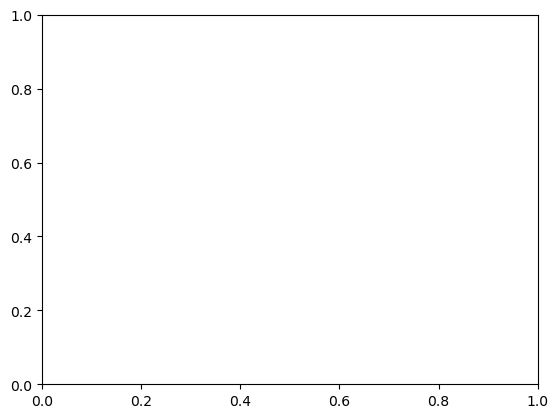

In [23]:
plt.plot(TensorDic_DenoisedGibbs["100-nii"].color_fa)

In [20]:
tenfit = TensorDic_DenoisedGibbs["100-nii"]

#ODF Construction
sphere = get_sphere('repulsion724')
tensor_odfs = tenfit.odf(sphere= sphere) # Create the ODF based on the sphere coordinates. 
#Mask Subset and mutate
tensor_odfs_masked = tensor_odfs[mask,:] #Turn all values outside of mask into False
tensor_odfs[mask == False] = 0 # Turn false into 0's.


#Plot and save ODF 
interactive = True #False = only save
scene = window.Scene() # Setup window
odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None) #create an actor
scene.add(odf_actor) #add actor to scene

#Save Image
print("Saving illustration as tensor_odfs.png")
window.record(scene=scene, n_frames=2, out_path="figures/tensor_odfs.png", size=(1080, 1080))

if interactive:
    window.show(scene)

MemoryError: Unable to allocate 11.9 GiB for an array with shape (724, 737280, 3) and data type float64

In [19]:
# Saving all ODF's in a single dictonairy.
mask_list = PathFinder("mask_axis_swapped.npy")

out_path1 = os.path.join('C:/DTI_SC/humanSC_400h/data', "ODF_dict0_14") + ".tkl"
out_path2 = os.path.join('C:/DTI_SC/humanSC_400h/data', "ODF_dict15_28") + ".tkl"

if os.path.exists(out_path1) & os.path.exists(out_path2):
    print("Already Exist")
else:
    
    ODF_Dict0_14 = {}
    ODF_Dict15_28 = {}

    for i, key in enumerate(TensorDic_DenoisedGibbs.keys()):
        print("Starting with: ", key, "i =", i)
        #load Mask
        mask = np.load(mask_list[i])
       
        #ODF Construction
        sphere = get_sphere('repulsion724')
        tensor_odfs = TensorDic_DenoisedGibbs[key].odf(sphere = sphere)
        tensor_odfs_masked = tensor_odfs[mask,:] #Turn all values outside of mask into False
        tensor_odfs[mask == False] = 0 # Turn false into 0's.
    
        if i < 15:
            ODF_Dict0_14[key] = tensor_odfs
        if i >= 15: 
            ODF_Dict15_28[key] = tensor_odfs

    with open(out_path1, 'wb') as f:
        pickle.dump(ODF_Dict0_14, f)
    
    with open(out_path2, 'wb') as f:
        pickle.dump(ODF_Dict15_28, f)

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\88-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\91-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\94-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\97-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\100-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\103-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\106-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\109-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\112-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\115-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\118-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\121-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\124-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\

MemoryError: Unable to allocate 3.98 GiB for an array with shape (724, 737280) and data type float64

In [49]:
mask_list = PathFinder("mask_axis_swapped.npy")
mask = np.load(mask_list[4])

#ODF Construction
sphere = get_sphere('repulsion724')
tensor_odfs = TensorDic_DenoisedGibbs["100-nii"].odf(sphere = sphere)
 
tensor_odfs_masked = tensor_odfs[mask,:] #Turn all values outside of mask into False
tensor_odfs[mask == False] = 0 # Turn false into 0's.


#Plot and save ODF 
interactive = True #False = only save
scene = window.Scene() # Setup window

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None) #create an actor
scene.add(odf_actor) #add actor to scene

#Save Image
print("Saving illustration as tensor_odfs.png")
window.record(scene=scene, n_frames=2, out_path="figures/tensor_odfs.png", size=(1080, 1080))


if interactive:
    window.show(scene)

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\88-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\91-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\94-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\97-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\100-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\103-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\106-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\109-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\112-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\115-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\118-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\121-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\124-nii\\mask_axis_swapped.npy', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\

# Plotting

The best SNR preprocessed data (denoised -> Gibbs)

In [202]:
#Load the Dict with all tensor models
with open('data/gibbs_denoised_affine_ok.tkl', 'rb') as f:
    TensorModelDic_final = pickle.load(f)

In [204]:
TensorModelDic_final.keys()

dict_keys(['88-nii', '91-nii', '94-nii', '97-nii', '100-nii', '103-nii', '106-nii', '109-nii', '112-nii', '115-nii', '118-nii', '121-nii', '124-nii', '127-nii', '130-nii', '133-nii', '136-nii', '139-nii', '142-nii', '145-nii', '148-nii', '151-nii', '154-nii', '157-nii', '160-nii', '163-nii', '166-nii', '169-nii', '172-nii'])

In [44]:
# Plotting All FA Color Maps and combining them. 
for key in TensorModelDic_final.keys():
    print("Starting with: ", key)
    temp = TensorModelDic_final[key]

    dir_path = os.path.join("C:/DTI_SC/humanSC_400h/figures/color_fa", key)

    if os.path.isdir(dir_path):
        print("Starting with", key)
        
    else:
        os.mkdir(dir_path)
        print(dir, ": DONT EXIST, building directory")
        print("Starting with ", key)

    for slice in np.arange(10,TensorModelDic_final[key].color_fa.shape[2]):
        print("Starting slice: ", slice)
        path = os.path.join(dir_path, "slice_" + str(slice) + ".png")
        
        if os.path.isfile(path):
            print(path, " does exist, skipping!")
            #os.remove(path)
        else:
            plot_color_fa(temp, ax_slice= slice, plot = False, save = True , save_path = path)

Starting with:  88-nii
Starting with 88-nii
Starting slice:  10
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_10.png  does exist, skipping!
Starting slice:  11
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_11.png  does exist, skipping!
Starting slice:  12
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_12.png  does exist, skipping!
Starting slice:  13
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_13.png  does exist, skipping!
Starting slice:  14
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_14.png  does exist, skipping!
Starting slice:  15
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_15.png  does exist, skipping!
Starting slice:  16
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_16.png  does exist, skipping!
Starting slice:  17
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_17.png  does exist, skipping!
Starting slice:  18
C:/DTI_SC/humanSC_400h/figures/color_fa\88-nii\slice_18.png  does exist, skipping!
Starting slice:  19
C:/DTI_SC

C:\Users\Bruger\AppData\Local\Temp\ipykernel_31980\2733741857.py:23: UserWarning: We'll no longer accept the way you call the record function in future versions of FURY.

Here's how to call the Function record: record(scene='value', cam_pos='value', cam_focal='value', cam_view='value', out_path='value', path_numbering='value', n_frames='value', az_ang='value', magnification='value', size='value', reset_camera='value', screen_clip='value', stereo='value', verbose='value')

  plot_color_fa(temp, ax_slice= slice, plot = False, save = True , save_path = path)


Starting slice:  62
Saving illustration as tensor_ellipsoids.png
Starting slice:  63
Saving illustration as tensor_ellipsoids.png
Starting slice:  64
Saving illustration as tensor_ellipsoids.png
Starting slice:  65
Saving illustration as tensor_ellipsoids.png
Starting slice:  66
Saving illustration as tensor_ellipsoids.png
Starting slice:  67
Saving illustration as tensor_ellipsoids.png
Starting slice:  68
Saving illustration as tensor_ellipsoids.png
Starting slice:  69
Saving illustration as tensor_ellipsoids.png
Starting slice:  70
Saving illustration as tensor_ellipsoids.png
Starting slice:  71
Saving illustration as tensor_ellipsoids.png
Starting slice:  72
Saving illustration as tensor_ellipsoids.png
Starting slice:  73
Saving illustration as tensor_ellipsoids.png
Starting slice:  74
Saving illustration as tensor_ellipsoids.png
Starting slice:  75
Saving illustration as tensor_ellipsoids.png
Starting slice:  76
Saving illustration as tensor_ellipsoids.png
Starting slice:  77
Savin

c:\DTI_SC\humanSC_400h\plot_functions.py:21: RuntimeWarning: invalid value encountered in divide
  cfa /= cfa.max()
c:\Users\Bruger\anaconda3\envs\ComputationalNeuro\Lib\site-packages\fury\actor.py:1393: RuntimeWarning: invalid value encountered in cast
  ).astype("ubyte")


Saving illustration as tensor_ellipsoids.png
Starting slice:  11
Saving illustration as tensor_ellipsoids.png
Starting slice:  12
Saving illustration as tensor_ellipsoids.png
Starting slice:  13
Saving illustration as tensor_ellipsoids.png
Starting slice:  14
Saving illustration as tensor_ellipsoids.png
Starting slice:  15
Saving illustration as tensor_ellipsoids.png
Starting slice:  16
Saving illustration as tensor_ellipsoids.png
Starting slice:  17
Saving illustration as tensor_ellipsoids.png
Starting slice:  18
Saving illustration as tensor_ellipsoids.png
Starting slice:  19
Saving illustration as tensor_ellipsoids.png
Starting slice:  20
Saving illustration as tensor_ellipsoids.png
Starting slice:  21
Saving illustration as tensor_ellipsoids.png
Starting slice:  22
Saving illustration as tensor_ellipsoids.png
Starting slice:  23
Saving illustration as tensor_ellipsoids.png
Starting slice:  24
Saving illustration as tensor_ellipsoids.png
Starting slice:  25
Saving illustration as te

Fully preprocessed data (Don't use this)

In [37]:
dti_fit = TensorModelDic_final["121-nii"]
sphere = get_sphere('repulsion724')
ax_slice = 10

# Enables/disables interactive visualization
interactive = True

scene = window.Scene()

evals = dti_fit.evals[:, :, ax_slice:ax_slice + 1]
evecs = dti_fit.evecs[:, :, ax_slice:ax_slice + 1]

cfa = dti_fit.color_fa[:, :, ax_slice:ax_slice + 1]
cfa /= cfa.max()

scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.7))

print('Saving illustration as tensor_ellipsoids.png')
#window.record(scene, n_frames=1, out_path='figures/tensor_ellipsoids.png',
#              size=(600, 600))
if interactive:
    window.show(scene)

Saving illustration as tensor_ellipsoids.png


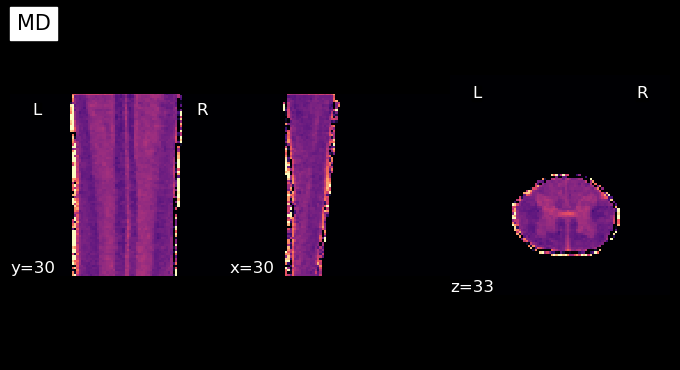

In [130]:
plotting.plot_anat(nib.Nifti1Image(TensorModelDic["103-nii"].rd, affine = np.eye(4)), cut_coords=[30,30,33],
                   dim=-1, draw_cross=False, cmap='magma', title='MD')
plotting.show()

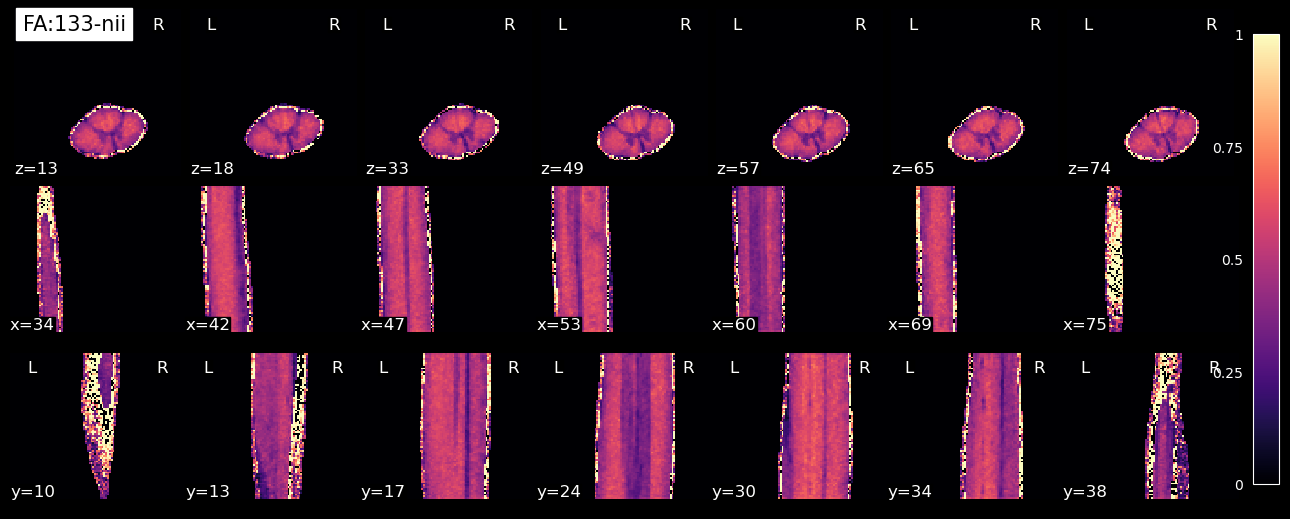

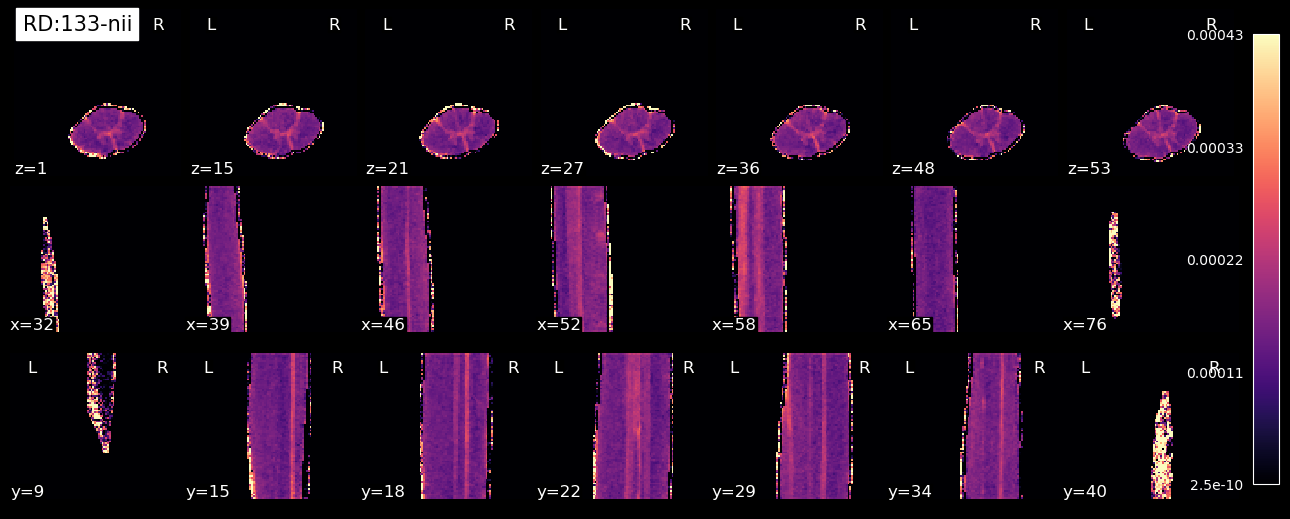

KeyboardInterrupt: 

In [132]:
import IPython.display

for key in TensorModelDic.keys():
    FA = TensorModelDic[key].fa
    RD = TensorModelDic[key].rd
    plotting.plot_anat(nib.Nifti1Image(FA,
                                        affine = np.eye(4)), 
                                        display_mode= "mosaic",
                                        dim=-1, 
                                        draw_cross=False, 
                                        cmap='magma', 
                                        title= "FA:" +key,
                                        colorbar= True,vmin=0, vmax = 1)
    plotting.show()

    plotting.plot_anat(nib.Nifti1Image(RD,
                                        affine = np.eye(4)), 
                                        display_mode= "mosaic",
                                        dim=-1, 
                                        draw_cross=False, 
                                        cmap='magma', 
                                        title= "RD:" +key,
                                        colorbar= True)
    
    
    plotting.show()
    while True:
        if keyboard.is_pressed('space'):
            print("Continuing...")
            plt.close('all')  # Close all matplotlib plots
            IPython.display.clear_output(wait=True)
            time.sleep(0.2)  # Small delay to avoid multiple triggers
            break

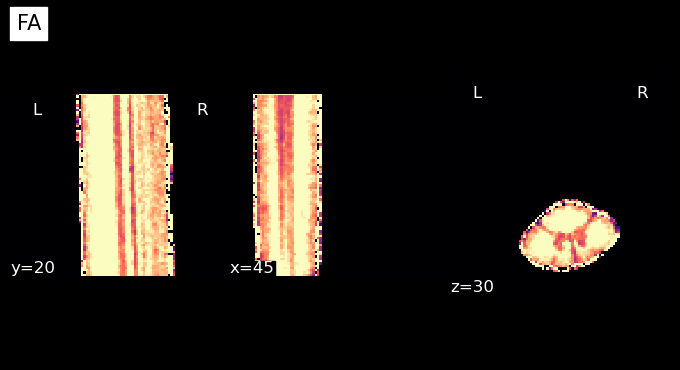

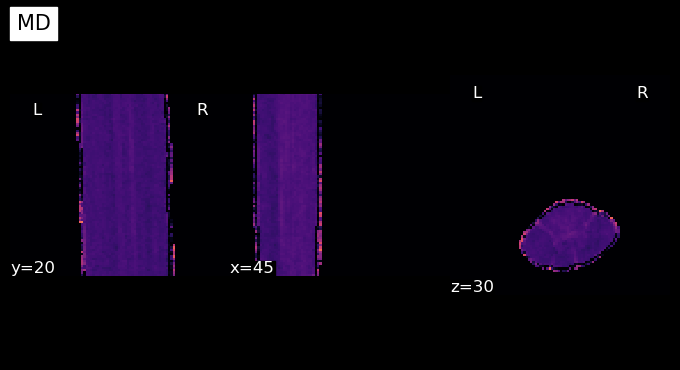

In [14]:

plotting.plot_anat(nib.Nifti1Image(FA, affine = np.eye(4)), cut_coords=[45,20,30],
                   dim=-1, draw_cross=False, cmap='magma', title='FA')


plotting.plot_anat(nib.Nifti1Image(MD, affine = np.eye(4)), cut_coords=[45,20,30],
                   dim=-1, draw_cross=False, cmap='magma', title='MD', vmax=0.001)

In [9]:
from dipy.reconst.dti import color_fa


#get the RGB values 
RGB = color_fa(FA, tenfit.evecs)

#create Sphere to use
sphere = get_sphere('symmetric724')

scene = window.Scene()

#Subset
evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]
cfa = RGB[13:43, 44:74, 28:29]
#cfa /= cfa.max()


structural_image = FA  # Use FA as an example structural image here
slice_idx = 66  # Z-slice to visualize

# Enables/disables interactive visualization
interactive = True

# Get the RGB values from FA and eigenvectors
RGB = color_fa(FA, tenfit.evecs)

# Create Sphere to use
sphere = get_sphere('symmetric724')

scene = window.Scene

# Subset Tensor Data
evals = tenfit.evals[:, :, 66:67]
evecs = tenfit.evecs[:, :, 66:67]
cfa = RGB[:, :, 66:67]
cfa /= cfa.max()

# Add tensor ellipsoids to the scene
scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=.5))

# Load structural image (e.g., FA map or T1-weighted image)
# Assume `structural_image` is a 3D numpy array (shape: [X, Y, Z])
structural_image = FA  # Use FA as an example structural image here
slice_idx = 66  # Z-slice to visualize

# Normalize the structural image for better visualization
structural_image /= structural_image.max()

# Add the structural image as a background slice
slicer = actor.slicer(structural_image, affine=np.eye(4))  # Adjust affine if necessary
slicer.display(None, None, slice_idx)  # Display only the desired slice
slicer.opacity(0.5)  

scene.add(slicer)

# Save the illustration
print('Saving illustration as tensor_ellipsoids_with_structural.png')
window.record(scene, n_frames=1, out_path='tensor_ellipsoids_with_structural.png', size=(600, 600))

# Show the visualization interactively if needed
if interactive:
    window.show(scene)

NameError: name 'FA' is not defined

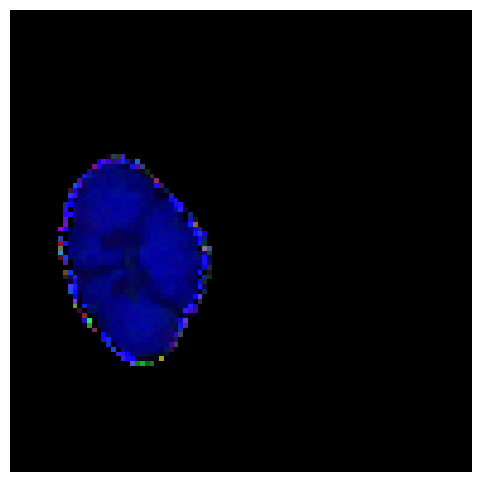

In [ ]:
# Let's visualize this
plt.figure(figsize=(6, 6))
plt.imshow(RGB[:, :, 31,:])
plt.axis('off');